## Imports

In [75]:
import numpy as np
import json
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
import pdb
import time

In [2]:
from __future__ import print_function
from sys import getsizeof, stderr
from itertools import chain
from collections import deque
try:
    from reprlib import repr
except ImportError:
    pass

def total_size(o, handlers={}, verbose=False):
    """ Returns the approximate memory footprint an object and all of its contents.

    Automatically finds the contents of the following builtin containers and
    their subclasses:  tuple, list, deque, dict, set and frozenset.
    To search other containers, add handlers to iterate over their contents:

        handlers = {SomeContainerClass: iter,
                    OtherContainerClass: OtherContainerClass.get_elements}

    """
    dict_handler = lambda d: chain.from_iterable(d.items())
    all_handlers = {tuple: iter,
                    list: iter,
                    deque: iter,
                    dict: dict_handler,
                    set: iter,
                    frozenset: iter,
                   }
    all_handlers.update(handlers)     # user handlers take precedence
    seen = set()                      # track which object id's have already been seen
    default_size = getsizeof(0)       # estimate sizeof object without __sizeof__

    def sizeof(o):
        if id(o) in seen:       # do not double count the same object
            return 0
        seen.add(id(o))
        s = getsizeof(o, default_size)

        if verbose:
            print(s, type(o), repr(o), file=stderr)

        for typ, handler in all_handlers.items():
            if isinstance(o, typ):
                s += sum(map(sizeof, handler(o)))
                break
        return s

    return sizeof(o)


## Read metadata from files

In [3]:
import os

# Get global object metadata
prod_dicts = []
for f in os.listdir("./fast-vol/ABO360/listings/metadata/"):
    print(f)
    with open(f"./fast-vol/ABO360/listings/metadata/{f}") as file:
        for line in file:
            prod_dicts.append(json.loads(line))

listings_c.json
listings_3.json
listings_d.json
listings_a.json
listings_f.json
listings_0.json
listings_2.json
listings_1.json
listings_4.json
listings_6.json
listings_9.json
listings_5.json
listings_b.json
listings_8.json
listings_7.json
listings_e.json


In [4]:
# Get catalog image metadata
import csv
with open(f"./fast-vol/ABO360/images/metadata/images.csv") as file:
    reader = csv.reader(file, delimiter=",", quotechar='"')
    # next(reader, None)  # skip the headers
    images_csv = [row for row in reader]

In [5]:
# Get spins image metadata
with open(f"./fast-vol/ABO360/spins/metadata/spins.csv") as file:
    reader = csv.reader(file, delimiter=",", quotechar='"')
    # next(reader, None)  # skip the headers
    spins_csv = [row for row in reader]

In [6]:
print(f"{len(images_csv)=}")
print(f"{len(spins_csv)=}")

len(images_csv)=398213
len(spins_csv)=586585


## Inspecting metadata, check for consistent format

In [15]:
# Check that every object in spins has exactly 72 images. Result: Almost true
spins_freqs = {}
for row in spins_csv:
    if row[0] not in spins_freqs:
        spins_freqs[row[0]] = 1
    else:
        spins_freqs[row[0]] += 1
c = 0
for id,freq in spins_freqs.items():
    if freq!=72:
        c+=1
        # print(id, freq)
    # assert freq==72
print(c, "out of", len(spins_freqs), "objects have 24 instead of 72 images, in spins data.")

94 out of 8210 objects have 24 instead of 72 images, in spins data.


In [22]:
spins_csv[0:3]

[['spin_id', 'azimuth', 'image_id', 'height', 'width', 'path'],
 ['61c91265',
  '0',
  '41wqHws7a6L',
  '248',
  '1075',
  '61/61c91265/61c91265_00.jpg'],
 ['61c91265',
  '1',
  '41++eZZHP9L',
  '248',
  '1075',
  '61/61c91265/61c91265_01.jpg']]

In [26]:
images_csv[0:3]

[['image_id', 'height', 'width', 'path'],
 ['010-mllS7JL', '106', '106', '14/14fe8812.jpg'],
 ['01dkn0Gyx0L', '122', '122', 'da/daab0cad.jpg']]

In [23]:
# Check for overlap between catalog images and spins
id_freqs = {}
for row in tqdm(images_csv):
    id = row[0]
    if id not in id_freqs:
        id_freqs[id] = 1
    else:
        id_freqs[id] += 1

for row in tqdm(spins_csv):
    id = row[2]
    if id not in id_freqs:
        id_freqs[id] = 1
    else:
        id_freqs[id] += 1

100% 398213/398213 [00:00<00:00, 828042.12it/s]
100% 586585/586585 [00:00<00:00, 789559.07it/s] 


In [24]:
for id,freq in id_freqs.items():
    if freq != 1:
        print(id, freq)
        # break

image_id 2
61I1JyT8E+L 2
71PcPB6KHIL 2


In [25]:
for row in images_csv:
    assert len(row)==4
for row in spins_csv:
    assert len(row)==6

In [27]:
has_dims = 0
unit_freqs = {
    "inches": 0
}
mismatches = 0
for d in tqdm(prod_dicts):
    if "item_dimensions" in d:
        has_dims += 1
        unit_types = (d["item_dimensions"]["height"]["unit"],
                      d["item_dimensions"]["width"]["unit"], 
                      d["item_dimensions"]["length"]["unit"])
        for unit in unit_types:
            if unit not in unit_freqs:
                unit_freqs[unit] = 1
            else:
                unit_freqs[unit] += 1
                
        if unit_types[0]==unit_types[1] and unit_types[1]==unit_types[2]:
            pass
        else:
            mismatches += 1

print(f"{mismatches=}")
pprint(unit_freqs)

100% 147702/147702 [00:00<00:00, 364111.37it/s]

mismatches=76
{'centimeters': 17639,
 'feet': 5,
 'inches': 103974,
 'meters': 8,
 'micrometer': 16,
 'millimeters': 8372}


In [29]:
# size_sum = 0
# for d in tqdm(prod_dicts):
#     size_sum += total_size(d)
# print(size_sum) # roughly 4-5 gb for all metadata dicts?

## Visualize image data (spins)

In [36]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
from IPython.display import display
from PIL import Image

def get_image(csv_row):
    if len(csv_row)==4:
        img_path = csv_row[3]
        img_path = f"./fast-vol/ABO360/images/small/{img_path}"
    elif len(csv_row)==6:
        img_path = csv_row[5]
        img_path = f"./fast-vol/ABO360/spins/original/{img_path}"
    img = Image.open(img_path)
    return img


In [77]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(list_of_imgs, title=None):
    fig = figure()
    number_of_imgs = len(list_of_imgs)
    if title is not None:
        fig.suptitle(title)
    for i in range(number_of_imgs):
        a=fig.add_subplot(1,number_of_imgs,i+1)
        image = list_of_imgs[i]
        imshow(image,cmap='Greys_r')
        axis('off')

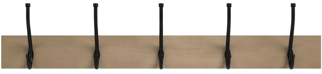

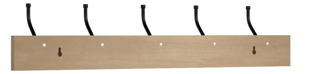

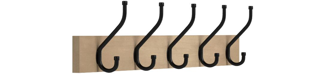

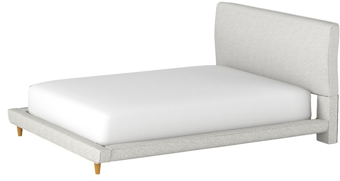

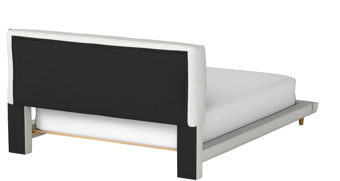

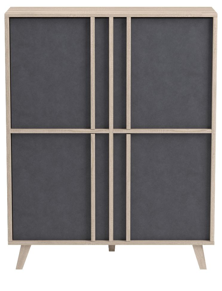

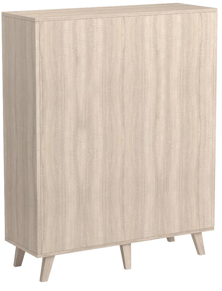

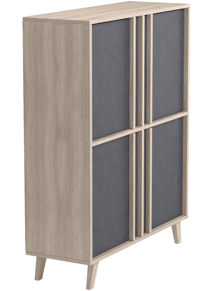

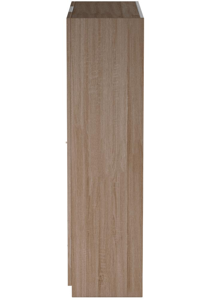

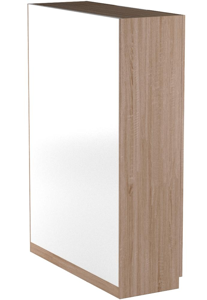

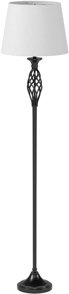

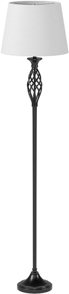

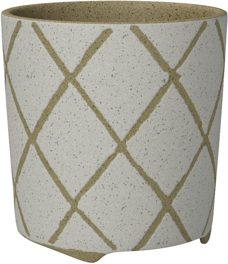

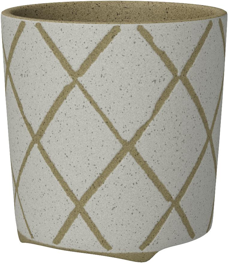

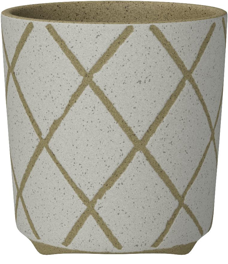

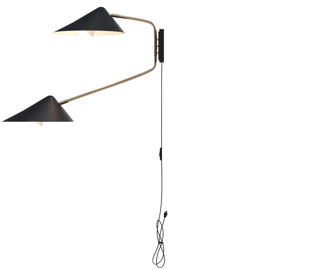

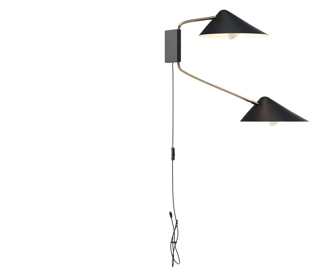

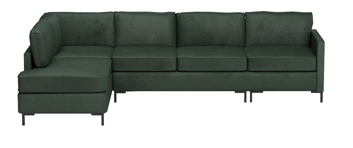

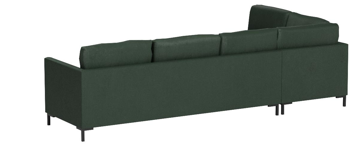

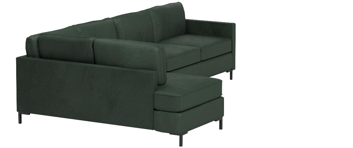

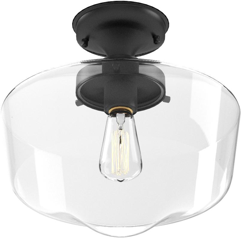

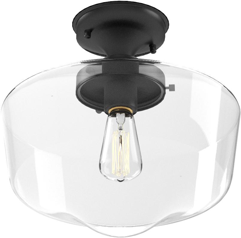

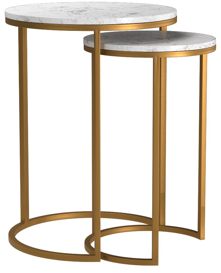

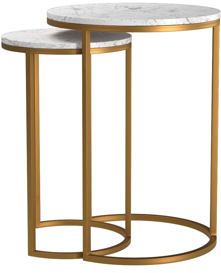

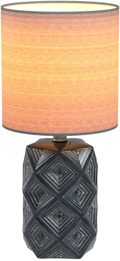

In [42]:
for i in range(1,(72+1)*10, 30):
    img = get_image(spins_csv[i])
    scale = 0.3
    img = img.resize(( int(img.width * scale), int(img.height * scale)))
    display(img)


## Preprocess for training: filter for objects with sizes

In [43]:
pprint(prod_dicts[0])

{'brand': [{'language_tag': 'en_IN', 'value': 'Amazon Brand - Solimo'}],
 'bullet_point': [{'language_tag': 'en_IN',
                   'value': 'Snug fit for Xiaomi Redmi Note 5, with perfect '
                            'cutouts for volume buttons, audio & charging '
                            'ports'},
                  {'language_tag': 'en_IN',
                   'value': 'Stylish design and appearance, express your '
                            'unique personality'},
                  {'language_tag': 'en_IN',
                   'value': 'High Resolution UV light-ion 3D Embossed Printing '
                            'for extraordinary quality and clarity. Printed '
                            'using high end advanced Japanese machines. Your '
                            'get our quality promise and design excellence'},
                  {'language_tag': 'en_IN',
                   'value': 'Extreme precision design allows easy access to '
                            'all button

In [44]:
combined_csv = {}
for row in images_csv:
    id = row[0]
    combined_csv[id] = row
for row in spins_csv:
    id = row[2]
    combined_csv[id] = row

In [68]:
len(prod_dicts)

147702

In [97]:

def validate_dims(dim_units, dim_values):
    # Note: feet, meters, micrometer almost never show up...
    accepted_units = ['centimeters', 'feet', 'inches', 'meters', 'micrometer', 'millimeters']
    valid = True
    # Should be a standard unit system (metric or imperial)
    for unit in dim_units:
        if unit not in accepted_units:
            valid = False
    # Should use the same unit system for length, width, height
    if not (dim_units[0]==dim_units[1] and dim_units[1]==dim_units[2]):
        valid = False
    # Should be positive values
    if not (dim_values[0]>0 and dim_values[1]>0 and dim_values[2]>0):
        valid = False
    return valid
        
def to_meters(dim_units, dim_values):
    dim_values = np.array(dim_values, dtype=np.float32)
    if dim_units[0]=='centimeters':
        dim_values*=0.01    
    elif dim_units[0]=='feet':
        dim_values*=0.3048
    elif dim_units[0]=='inches':
        dim_values*=0.0254
    elif dim_units[0]=='meters':
        dim_values
    elif dim_units[0]=='micrometer':
        dim_values*=1e-6
    elif dim_units[0]=='millimeters':
        dim_values*=0.001
    else:
        dim_values = None
    assert dim_values is not None
    return dim_values.tolist()
        
num_img_freqs = []
id_to_object = {}
# filtered_image_ids = {}
counter = 0
num_conflicts = 0
has_spin_id = 0
for idx, d in enumerate(tqdm(prod_dicts)):
    if "item_dimensions" in d:
        # Extract dimensions
        dim_units = (
            d["item_dimensions"]["width"]["unit"],
            d["item_dimensions"]["height"]["unit"],
            d["item_dimensions"]["length"]["unit"]
        )
        dim_values = (
            d["item_dimensions"]["width"]["value"],
            d["item_dimensions"]["height"]["value"],
            d["item_dimensions"]["length"]["value"]
        )
        # Validate, standardize to meters
        if validate_dims(dim_units, dim_values):
            meter_values = to_meters(dim_units, dim_values)
            w,h,l = meter_values
            meter_values = (round(w,5),round(h,5),round(l,5))
            # if idx<4:
            #     print(f"{meter_values=}")
            too_small = False
            if min(meter_values)<=0.05:
                # print(f"Too small! {meter_values=}")
                too_small = True
                # continue
                
            subdict = {
                "item_dimensions": meter_values,
                "axes_order": ("width","height","length"),
                "dimensions_unit": "meters"
            }
            # Get extra relevant metadata
            for k in ["item_id", "item_keywords", "item_name", "item_weight", "product_type", "main_image_id", "other_image_id", "spin_id", "product_type"]:
                if k in d:
                    subdict[k] = d[k]

            # Create mapping from image_id to index of its prod_dict in the filtered list
            ids = []
            num_ids = 0
            if "spin_id" in d:
                has_spin_id += 1
            if "main_image_id" in d:
                ids += [d["main_image_id"]]
                num_ids += 1
                # print(f"{d['main_image_id']=}")
                # get_image(combined_csv[ids[0]])
                # if ids[-1]=="81tp5UABhbL":
                #     pdb.set_trace()
            if "other_image_id" in d:
                ids += d["other_image_id"]
                num_ids += len(d["other_image_id"])
                # if "81tp5UABhbL" in d["other_image_id"]:
                #     pdb.set_trace()
                
                # for id in d["other_image_id"]:
                #     print(f"{id=}")
                #     get_image(combined_csv[id])
                # print()
                # print()
                # print()
            # filtered_prod_dict_idx = len(filtered)
            # conflict_id = False
            if num_ids>=6:
                num_ids = 1
                ids = ids[0:1]  
            num_img_freqs.append(num_ids)
            conflict_ids = []
            for id in ids:
                if id not in id_to_object:
                    id_to_object[id] = subdict #filtered_prod_dict_idx
                else:
                    num_conflicts += 1
                    # print(f"For image id key {id}, changing existing value.")
                        # idx: {id_to_object[id]} --> {filtered_prod_dict_idx}
                    # pdb.set_trace()
                    # get_image(combined_csv[id])
                    # conflict_id = True
                    conflict_ids.append(id)
                    # del id_to_object[id]
                    # id_to_object[id] = filtered_prod_dict_idx
                    # counter += 1
            '''
            # Visualize every kth product
            # if idx%1==0:
            if num_ids==0:
                print(d)
            else:
                # print(f"{meter_values=}")
                if num_ids>=6:
                    ids = ids[0:1]    
                list_of_imgs = [get_image(combined_csv[id]) for id in ids if id not in conflict_ids]
                showImagesHorizontally(list_of_imgs) #, title=str(d["item_name"])+str(meter_values)
                # time.sleep(0.01)
                # print()
                # print()
            counter += 1
            if counter > 100:
                break
                
                # get_image(combined_csv[id])
            # filtered.append(subdict)
            '''
            
# print(f"{len(filtered)=}")
print(f"{len(id_to_object)=}")
print(f"{num_conflicts=}")
# print(f"{len(filtered_image_ids)=}", f"{len(images_csv)+len(spins_csv)=}")
print(f"{has_spin_id=}")

100% 147702/147702 [00:01<00:00, 129659.03it/s]

len(id_to_object)=81375
num_conflicts=19731
has_spin_id=8047


In [98]:
sum(num_img_freqs)

101106

In [92]:
sum(num_img_freqs)

42640

In [90]:
sum(num_img_freqs)

236827

(array([ 6.,  3.,  7., 11., 20., 41.,  4.,  4.,  2.,  3.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

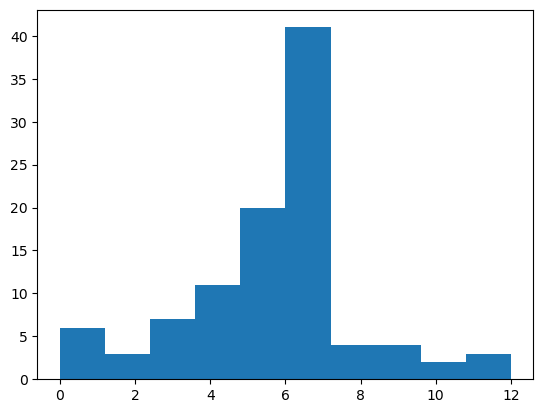

In [73]:
plt.hist(num_img_freqs)

In [57]:
plt.close("all")

In [ ]:
# id_to_object["81tp5UABhbL"]
# 86032
# 'item_id': 'B074VDHXHB'


# images csv: 337841	7e/7ecf343f.jpg

# Conclusion: 365 Everyday Value Vegetable Broth and Sliced Bread go to the same other_image_id,
# which is a generic 365 brand logo.

In [99]:
len(id_to_object)

81375

In [64]:
k0 = list(id_to_object.keys())[0]
for id,dict in id_to_object.items():
    if dict==id_to_object[k0]:
        print(id)

A1FxQMYARCL
91jNP6GuOEL
91B5Kc2RrPL
A1R52-KzBFL
A1SqXogtj1L


In [66]:
pprint(id_to_object[k0])
print()
pprint(id_to_object["91jNP6GuOEL"])

{'axes_order': ('width', 'height', 'length'),
 'dimensions_unit': 'meters',
 'item_dimensions': [0.7848599553108215,
                     0.7797800302505493,
                     1.0642600059509277],
 'item_id': 'B07GPG2NGM',
 'item_keywords': [{'language_tag': 'en_SG', 'value': 'pet-crates'},
                   {'language_tag': 'en_SG', 'value': 'pet-crates'},
                   {'language_tag': 'en_SG', 'value': 'pet-crates'},
                   {'language_tag': 'en_SG', 'value': 'pet-crates'},
                   {'language_tag': 'en_SG', 'value': 'pet-crates'},
                   {'language_tag': 'en_SG', 'value': 'pet-crates'},
                   {'language_tag': 'en_SG', 'value': 'pet-crates'},
                   {'language_tag': 'en_SG', 'value': 'pet-crates'},
                   {'language_tag': 'en_SG', 'value': 'pet-crates'},
                   {'language_tag': 'en_SG', 'value': 'pet-crates'},
                   {'language_tag': 'en_SG', 'value': 'pet-crates'},
               

In [ ]:

# filtered_csv = []
for id,prod_dict in id_to_object.items():
    csv_row = combined_csv[id]
    id_to_object[id] = {
        "prod_dict":prod_dict,
        "csv_row":csv_row
    }
    # for row in combined_csv:
    #     if len(row)==4:
    #         if row[0]==id:
    #             filtered_
    #     elif len(row)==6:
    #         if row[2]==id:
    #             combined_csv

In [ ]:
len(filtered)

In [ ]:
filtered[0]

In [ ]:
with open("./fast-vol/ABO360/listings/metadata/listingsWithDims.json", "w") as f:
    json.dump(filtered, f)